## Inspired by https://juanitorduz.github.io/spectral_clustering/

Đã đọc hiểu và customize code và lược đi các đoạn không cần thiết.

## Khởi tạo các thư viện cần thiết.

In [1]:
## loading python libraries

# necessary to display plots inline:
%matplotlib inline   

# load the libraries
import matplotlib.pyplot as plt # 2D plotting library
import numpy as np              # package for scientific computing 
import pandas as pd
import seaborn as sns           # coloring seaborn
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Dataset đường tròn đồng tâm.

Trong đoạn code thuật toán Spectral Clustering này chúng ta sẽ chạy code dựa trên dataset 3 hình tròn đồng tâm, dưới đây chúng ta sẽ tự sinh ra các đường tròn đồng tâm.

In [2]:
np.random.seed(np.random.randint(1, 100))

def generate_circle(r, n, std):
    """Hàm tạo ra đường tròn"""
    angles = np.random.uniform(low = 0, high = 2 * np.pi, size = n)

    x_eps = np.random.normal(loc = 0.0, scale = std, size = n)
    y_eps = np.random.normal(loc = 0.0, scale = std, size = n)

    x = r * np.cos(angles) + x_eps
    y = r * np.sin(angles) + y_eps
    return x, y

def generate_circles_data(circle_list):
    """Hàm tạo ra các đường tròn khác nhau"""
    points = [ 
        generate_circle(circle[0], circle[1], circle[2]) #radius, number of samples, std
     for circle in circle_list
    ]
    return points

Plot các đường tròn.

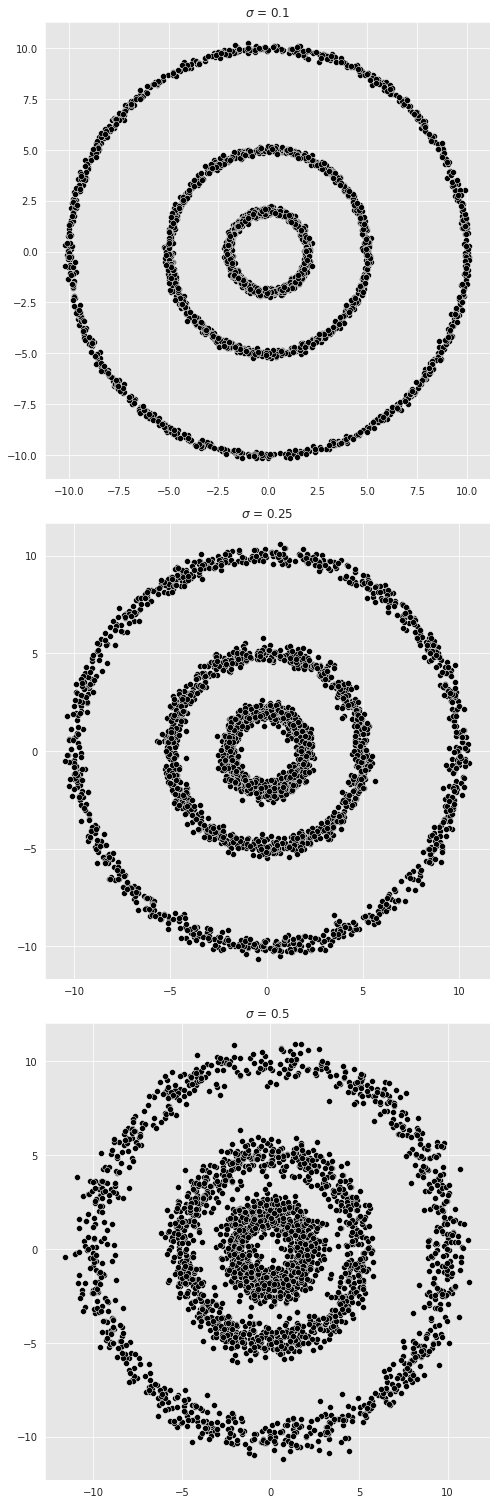

In [3]:
# Number of points per circle. 
n = 1000
# Radius. 
r_list = [2, 5, 10]
# Standard deviation (Gaussian noise). 
stds = [0.1, 0.25, 0.5]

data_sets = [[(r, n, std) for r in r_list] for std in stds]

# List này chứa list các điểm(các datasets khác nhau)
coordinates_list = []

fig, axes = plt.subplots(3, 1, figsize=(7, 21))

for i, data_set in enumerate(data_sets):

    coordinates = generate_circles_data(data_set)
    coordinates_list.append(coordinates)
    
    ax = axes[i]
    for j in range(0, len(coordinates)):
        
        x, y = coordinates[j]
        sns.scatterplot(x = x, y = y, color = 'black', ax = ax)
        ax.set(title = f'$\sigma$ = {data_set[0][2]}')

plt.tight_layout()

Chuyển dữ liệu chúng ta sử dụng thành dạng dataframe của pandas

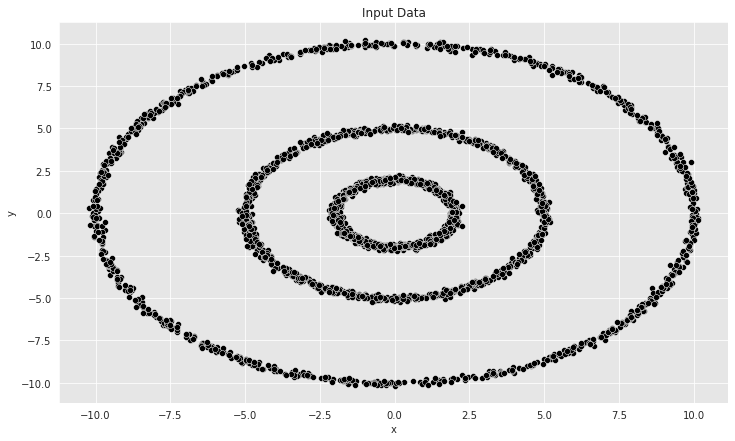

In [4]:
from itertools import chain

coordinates = coordinates_list[0]

def data_frame_from_coordinates(coordinates): 
    """Chuyển đổi sang dataframe"""
    xs = chain(*[c[0] for c in coordinates])
    ys = chain(*[c[1] for c in coordinates])
    
    return pd.DataFrame(data={'x': xs, 'y': ys})

data_to_be_used = data_frame_from_coordinates(coordinates)
data_df = data_frame_from_coordinates(coordinates)

# Plot the input data.
fig, ax = plt.subplots(figsize = (12, 7))
sns.scatterplot(x='x', y='y', color='black', data=data_df, ax=ax)
ax.set(title='Input Data');

Thử thuật toán K-means với 3 clusters

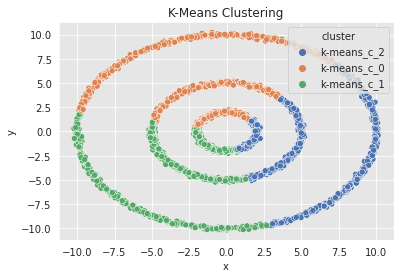

In [5]:
from sklearn.cluster import KMeans

k_means = KMeans(n_clusters=3)
k_means.fit(data_df)
cluster = k_means.predict(data_df)

cluster = ['k-means_c_' + str(c) for c in cluster]

fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', data=data_df.assign(cluster = cluster), hue='cluster')
ax.set(title='K-Means Clustering');

## Bước 1: Tạo ra graph Laplacian matrix
Dưới đây chúng ta sẽ sử dụng k-nearest neighbors để sinh ra ma trận.

In [6]:
from sklearn.neighbors import kneighbors_graph
from scipy import sparse

def k_nearest_neighbors(df, nn):
    """Dùng thuật toán knn"""
    # Ma trận kề.
    connectivity = kneighbors_graph(X=df, n_neighbors=nn, mode='connectivity')
    adjacency_matrix_s = (1/2)*(connectivity + connectivity.T)
    # Ma trận Laplacian.
    graph_laplacian_s = sparse.csgraph.laplacian(csgraph=adjacency_matrix_s, normed=False)
    graph_laplacian = graph_laplacian_s.toarray()
    return graph_laplacian
    
def generate_graph_laplacian(df, nn, method):
    """Hàm tạo ra graph Laplacian dựa trên method mình chọn"""
    if method == 'k-nearest-neighbor':
        return k_nearest_neighbors(df, nn) 
graph_laplacian = generate_graph_laplacian(data_df, 8, 'k-nearest-neighbor')

## Bước 2: Tính eigenvalues và eigenvectors

In [7]:
from scipy import linalg

def compute_spectrum(graph_laplacian):
    """Tính eigenvalues and eigenvector của ma trận laplacian."""
    eigenvals, eigenvcts = linalg.eig(graph_laplacian)
    eigenvals = np.real(eigenvals)
    eigenvcts = np.real(eigenvcts)
    return eigenvals, eigenvcts

eigenvals, eigenvcts = compute_spectrum(graph_laplacian)

## Bước 3: Dự đoán số clusters  

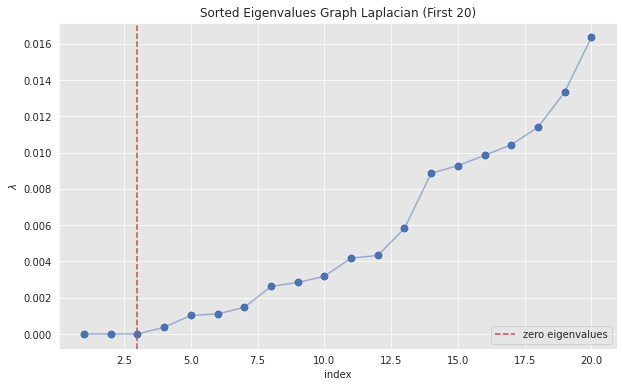

In [8]:
index_lim = 20

eigenvals_sorted_indices = np.argsort(eigenvals)
eigenvals_sorted = eigenvals[eigenvals_sorted_indices]

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=range(1, eigenvals_sorted_indices[: index_lim].size + 1), y=eigenvals_sorted[: index_lim], s=80, ax=ax)
sns.lineplot(x=range(1, eigenvals_sorted_indices[: index_lim].size + 1), y=eigenvals_sorted[: index_lim], alpha=0.5, ax=ax)
ax.axvline(x=3, color=sns_c[3], label='zero eigenvalues', linestyle='--')
ax.legend()
ax.set(title=f'Sorted Eigenvalues Graph Laplacian (First {index_lim})', xlabel='index', ylabel=r'$\lambda$');

In [9]:
zero_eigenvals_index = np.argwhere(abs(eigenvals) < 1e-5)
eigenvals[zero_eigenvals_index]

array([[ 1.17700988e-15],
       [ 2.09583236e-17],
       [-5.71157704e-16]])

Nhận thấy 3 eigenvalues đầu gần như 0, nên chúng ta dự đoán số clusters là 3.

## Bước 4: Lập ra ma trận gồm các eigenvectors đặc biệt.

In [10]:
def project_and_transpose(eigenvals, eigenvcts, num_ev):
    """Chọn num_ev eigenvectors đầu tiên dựa trên list eigenvalues đã được sorted là columns trong data frame."""
    eigenvals_sorted_indices = np.argsort(eigenvals)
    indices = eigenvals_sorted_indices[: num_ev]

    proj_df = pd.DataFrame(eigenvcts[:, indices.squeeze()])
    proj_df.columns = ['v_' + str(c) for c in proj_df.columns]
    return proj_df

## Bước 5: Chạy K-means trên ma trận này

In [11]:
def run_k_means(df, n_clusters):
    """K-means clustering."""
    k_means = KMeans(random_state=25, n_clusters=n_clusters)
    k_means.fit(df)
    cluster = k_means.predict(df)
    return cluster

cluster = run_k_means(project_and_transpose(eigenvals, eigenvcts, 3), n_clusters = 3)

## Bước 6: Plot thuật toán Spectral Clustering trên datasets

[Text(0.5, 1.0, 'Spectral Clustering')]

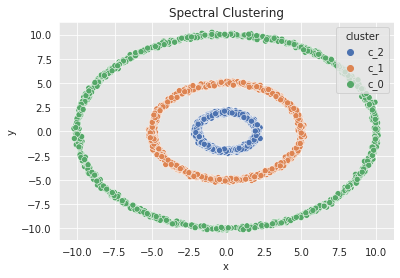

In [12]:
data_df['cluster'] = ['c_' + str(c) for c in cluster]

fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', data=data_df, hue='cluster', ax=ax)
ax.set(title='Spectral Clustering')

Giờ chúng ta tổng quát các bước trong một hàm Spectral Clustering.

In [13]:
def spectral_clustering(df, n_neighbors, n_clusters):
    """Spectral Clustering Algorithm."""
    graph_laplacian = generate_graph_laplacian(df, n_neighbors, 'k-nearest-neighbor')
    eigenvals, eigenvcts = compute_spectrum(graph_laplacian)
    proj_df = project_and_transpose(eigenvals, eigenvcts, n_clusters)
    cluster = run_k_means(proj_df, proj_df.columns.size)
    return [str(c) for c in cluster]

In [ ]:
data_df['cluster'] = ['c_' + str(c) for c in spectral_clustering(data_to_be_used, 8, 3)]

fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', data=data_df, hue='cluster', ax=ax)
ax.set(title='Spectral Clustering')